## Name: {James Chung}

## Homework 3: Data Security & Privacy

## Grading Rubric

Questions 1-4 are worth **3 points total**.  
Question 5 is worth **7 points**.  
Total: **10 points**

## Tools

#### Libraries:
  
- pandas and numpy: for data processing 
- seaborn and matplotlib: for plotting  
- sklearn: for models
- diffprivlib: differential privacy examples

#### Datasets:

[Apple Watch](https://www.kaggle.com/datasets/aleespinosa/apple-watch-and-fitbit-data/data)

Fuller, Daniel. (2020) Replication Data for: Using machine learning methods to predict physical activity types with Apple Watch and Fitbit data using indirect calorimetry as the criterion. Harvard Dataverse. [doi: 10.7910/DVN/ZS2Z2J](https://doi.org/10.7910/DVN/ZS2Z2J) 

## Table of Contents

* [1. Apple Watch Data Exploration](#one)
* [2. Centralized Statistics and Models](#two)
* [3. Differential Privacy Statistics](#three)
* [4. Federated Models](#four)
* [5. Conclusion](#five)

## Goals

In this assignment we explore the concepts of differential privacy (DP) and federated learning (FL) on a simple example dataset of Apple Watch data for multiple users. We will see how we can use DP to generate statistics and summaries of the data in a way that protects the raw data. Then we will use FL to train a model using each individual's Apple Watch data independently, as if that data were stored on each individual's device, and not centralized. Training a good model is **not** the point of this exercise, however, this data was collected, cleaned, processed, and modeled as part of an experiment, which you can read about [here](https://assets.researchsquare.com/files/rs-17022/v1/d5923374-d56c-4fe7-a036-949ecf41917e.pdf?c=1631831698) if you'd like. 

At the end of this assignment, we will be more familiar with DP and FL. Note that this simple notebook is not enough to encapsulate all of the challenges with these topics. They are both very complex, so much so that many companies have not bothered to try implementing them.

## Setup

First, let's load the libraries. Remember to install any libraries not already installed.

In [12]:
# !pip install -q diffprivlib

In [24]:
import numpy as np
import pandas as pd
import diffprivlib as dp
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression

## 1. Apple Watch Data Exploration <a id="one"></a>

First we will load the data and quickly take a look at it to get a better understanding. We do not need to generate any summary statistics or histograms yet, we will do that in the next section. For more details on how this dataset was created, see [this](https://assets.researchsquare.com/files/rs-17022/v1/d5923374-d56c-4fe7-a036-949ecf41917e.pdf?c=1631831698).

The data does not come with a unique identifier, so we will create one using the age, gender and height of the individuals under the assumption that no individual aged or got taller or shorter during the time this data was collected, and that no two individuals have identical ages, genders and heights. In future sections we will want to train some models, predicting the `activity_trimmed` column based on the user's watch measurements and their age, gender, height, and weight (which we might say are *sensitive* characteristics).

In [14]:
data_path = 'data_for_weka_aw.csv'
data = pd.read_csv(data_path)
data.head()

,Unnamed: 0,age,gender,height,weight,Applewatch.Steps_LE,Applewatch.Heart_LE,Applewatch.Calories_LE,Applewatch.Distance_LE,EntropyApplewatchHeartPerDay_LE,EntropyApplewatchStepsPerDay_LE,RestingApplewatchHeartrate_LE,CorrelationApplewatchHeartrateSteps_LE,NormalizedApplewatchHeartrate_LE,ApplewatchIntensity_LE,SDNormalizedApplewatchHR_LE,ApplewatchStepsXDistance_LE,activity_trimmed
0,1,20,1,168.0,65.4,10.771429,78.531302,0.344533,0.008327,6.221612,6.116349,59.0,1.000000,19.531302,0.138520,1.000000,0.089692,Lying
1,2,20,1,168.0,65.4,11.475325,78.453390,3.287625,0.008896,6.221612,6.116349,59.0,1.000000,19.453390,0.137967,1.000000,0.102088,Lying
2,3,20,1,168.0,65.4,12.179221,78.540825,9.484000,0.009466,6.221612,6.116349,59.0,1.000000,19.540825,0.138587,1.000000,0.115287,Lying
3,4,20,1,168.0,65.4,12.883117,78.628260,10.154556,0.010035,6.221612,6.116349,59.0,1.000000,19.628260,0.139208,1.000000,0.129286,Lying
4,5,20,1,168.0,65.4,13.587013,78.715695,10.825111,0.010605,6.221612,6.116349,59.0,0.982816,19.715695,0.139828,0.241567,0.144088,Lying


In [15]:
# Create the id column for users
data['id'] = data.apply(lambda row: '_'.join([str(row.age), str(row.gender), str(row.height)]), axis=1)
data.drop(columns = 'Unnamed: 0', inplace = True)
data.id.unique().shape

(47,)

**Question 1a:** Why would an Apple Watch user want to preserve their privacy?  

**Answer:** It is the same reason as any user on any website would like to maintain their privacy. If data privacy is breached, many problems can break, e.g. a user can be subject to by unwanted targetted advertisements.

**Question 1b:** What data might be collected that a user may not want in the hands of a "bad actor" or a company? Note that this dataset we're using here only contains a sampling of what could technically be collected.

**Answer:** heart rate, steps per day, weight, activity_trimmed

## 2. Centralized Statistics and Models<a id="two"></a>

In this section, let's pretend that we do not care about data privacy, and let's use the entire centralized collection of raw data to generate summary statistics, histograms, and a model. We'll use these results to compare against the results that we get when we use DP and FL. We do not need to generate summary stats and histograms for all columns, we'll just pick a couple of them to focus on.

In [16]:
data.describe()

,age,gender,height,weight,Applewatch.Steps_LE,Applewatch.Heart_LE,Applewatch.Calories_LE,Applewatch.Distance_LE,EntropyApplewatchHeartPerDay_LE,EntropyApplewatchStepsPerDay_LE,RestingApplewatchHeartrate_LE,CorrelationApplewatchHeartrateSteps_LE,NormalizedApplewatchHeartrate_LE,ApplewatchIntensity_LE,SDNormalizedApplewatchHR_LE,ApplewatchStepsXDistance_LE
count,3656.000000,3656.000000,3656.000000,3656.000000,3656.000000,3656.000000,3656.000000,3656.000000,3656.000000,3656.000000,3656.000000,3656.000000,3656.000000,3656.000000,3656.000000,3656.000000
mean,29.408096,0.473468,169.879595,70.611461,180.246421,91.250821,5.783917,0.084236,6.123775,6.053414,68.374613,0.006167,22.876208,0.191443,8.847003,39.661894
std,9.037922,0.499364,10.428342,14.124498,269.437917,26.753167,7.278513,0.136905,0.215706,0.176805,11.929595,0.741244,23.967587,0.205107,10.076715,112.409742
min,18.000000,0.000000,143.000000,43.000000,1.000000,33.000000,0.056269,0.000440,5.118769,5.655310,34.153846,-1.000000,-31.531302,-0.270728,0.003231,0.000690
25%,23.000000,0.000000,160.000000,60.500000,10.771429,75.457510,0.459917,0.007865,6.075165,5.909440,60.000000,-0.737777,5.800000,0.048140,1.682028,0.089692
50%,28.000000,0.000000,168.000000,70.000000,60.133571,83.624783,0.756000,0.030825,6.175485,6.084968,69.600000,0.008458,15.436350,0.125506,5.201685,2.057531
75%,33.000000,1.000000,180.000000,79.300000,203.273333,102.517857,13.807992,0.080943,6.228819,6.189825,78.456592,0.776200,30.716270,0.259667,12.124746,15.240782
max,56.000000,1.000000,191.000000,115.000000,1714.000000,194.333333,29.242000,1.087790,6.408318,6.409391,97.000000,1.000000,128.500000,1.297980,56.138088,1721.421620


In [17]:
# select any two columns you want
column_names = ['Applewatch.Steps_LE', 'Applewatch.Heart_LE']

# first we will look at the total mean and median values, and then we can grab the ones grouped by id
all_stats = data[column_names].agg(['mean', 'median'])
id_stats = data.groupby(['id'])[column_names].agg(['mean', 'median'])

all_stats

,Applewatch.Steps_LE,Applewatch.Heart_LE
mean,180.246421,91.250821
median,60.133571,83.624783


array([[<Axes: title={'center': 'Applewatch.Steps_LE'}>,
        <Axes: title={'center': 'Applewatch.Heart_LE'}>]], dtype=object)

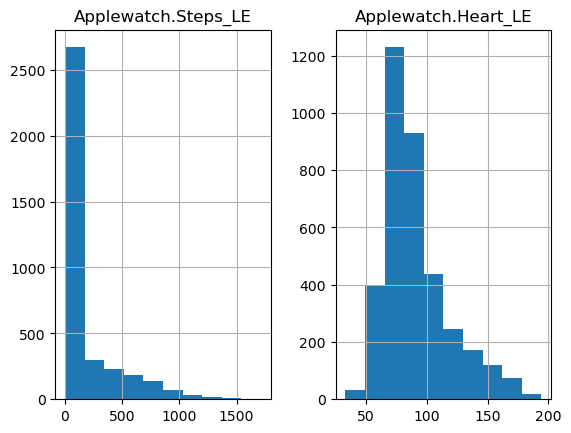

In [18]:
data[column_names].hist()

Now we can train a very simplistic regularized logistic regression model on the centralized dataset. When we train the model, we want to easily compare it to a privacy-preserving version of the model that we will be training later, so let's simplify the data a little bit by bucketing our target variable, `activity_trimmed` into just two categories: `Still` and `Active`, and then we'll convert it to a binary (0,1) variable for classification. We also will not do any extensive feature selection, we can just do a quick LASSO model and select a few features to keep in the final model.

In [19]:
mapping = {
    'Lying': 'Still',
    'Sitting': 'Still',
    'Self Pace walk': 'Active',
    'Running 3 METs': 'Active',
    'Running 5 METs': 'Active',
    'Running 7 METs': 'Active'
}

# Apply the mapping to the 'my_column' column
data['activity_binary'] = data['activity_trimmed'].map(mapping)

In [20]:
le = LabelEncoder()
lefit = le.fit(data['activity_binary'])
activity=lefit.transform(data['activity_binary'])
print(data['activity_binary'].unique())
print(np.unique(activity))

['Still' 'Active']
[0 1]


Now we can create our feature (X) and target (y) data for modeling. We'll use a simple random train/test split even though we know that a user's data may end up in both sets, which may result in leakage. Like we said earlier, the goal here isn't to train a very good model. But, if we were doing this properly we might identify data from each user that we can use as an out-of-time test data set by choosing the most recently recorded data (unfortunately, datetime is not included in the dataset), and allow the model to train on a portion of each user's data. Or, maybe we exclude a sample of our users' data entirely from training and only include those users in the testing set to see if a model that is trained on one set of users can be used to predict on other sets of users. 

In [21]:
data['activity_binary']=activity
target1 = data['activity_binary'] 
feature_data = data.drop(columns = ['id', 'activity_binary', 'activity_trimmed'])
feature_data = data.drop(columns = ['activity_binary', 'activity_trimmed'])

In [22]:
feature_data.head()

,age,gender,height,weight,Applewatch.Steps_LE,Applewatch.Heart_LE,Applewatch.Calories_LE,Applewatch.Distance_LE,EntropyApplewatchHeartPerDay_LE,EntropyApplewatchStepsPerDay_LE,RestingApplewatchHeartrate_LE,CorrelationApplewatchHeartrateSteps_LE,NormalizedApplewatchHeartrate_LE,ApplewatchIntensity_LE,SDNormalizedApplewatchHR_LE,ApplewatchStepsXDistance_LE,id
0,20,1,168.0,65.4,10.771429,78.531302,0.344533,0.008327,6.221612,6.116349,59.0,1.000000,19.531302,0.138520,1.000000,0.089692,20_1_168.0
1,20,1,168.0,65.4,11.475325,78.453390,3.287625,0.008896,6.221612,6.116349,59.0,1.000000,19.453390,0.137967,1.000000,0.102088,20_1_168.0
2,20,1,168.0,65.4,12.179221,78.540825,9.484000,0.009466,6.221612,6.116349,59.0,1.000000,19.540825,0.138587,1.000000,0.115287,20_1_168.0
3,20,1,168.0,65.4,12.883117,78.628260,10.154556,0.010035,6.221612,6.116349,59.0,1.000000,19.628260,0.139208,1.000000,0.129286,20_1_168.0
4,20,1,168.0,65.4,13.587013,78.715695,10.825111,0.010605,6.221612,6.116349,59.0,0.982816,19.715695,0.139828,0.241567,0.144088,20_1_168.0


In [26]:
# create train/test splits
X_train, X_test, y_train, y_test = train_test_split(feature_data, activity, test_size=0.2)

X_train_id = X_train['id'] # useful for later when we do federated learning
X_train = X_train.drop(columns='id')
X_test = X_test.drop(columns='id')

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

# Create a logistic regression model with lasso regularization
l_model = LogisticRegression(solver='liblinear', penalty='l1', C=.01)
l_model.fit(X_train, y_train)

LogisticRegression(C=0.01, penalty='l1', solver='liblinear')

In the above model you can change the value of `C` in order to do more or less shrinkage of the coefficients and select a final set of features for the model, and then examine the coefficients and model performance on the test set below. In the model above I specifically chose a value for the shrinkage parameter that would lead to a sparse model, which will make it easier later when we compare to the output we get from a privacy-preserving model, but feel free to modify the code and rerun.

In [27]:
l_model.coef_

array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.00220281, -0.01518471, -0.57394951,  0.05934722,
         0.        ]])

In [28]:
y_pred = l_model.predict_proba(X_test)
auc_score = roc_auc_score(y_test, y_pred[:,1])

# Print AUC score
print(f"All AUC scores: {auc_score}")

All AUC scores: 0.6737850235556657


## 3. Differential Privacy Statistics <a id="three"></a>

Now that we have our statistics and a trained model using the full dataset, with no privacy, we can compare the results with the results we would get using DP. We will only be using Central DP (CDP) in these examples, and will not do anything with Local DP (LDP). The difference between CDP and LDP is that with CDP we have a trusted central server that is responsible for taking any aggregates of the raw data (e.g. mean, median) and adding noise to the aggregates in order to avoid any leakage of the underlying data. With LDP, the noise is added before aggregating, on the client side, which reduces some risk of leakage, but also tends to result in less accurate summaries.

There are many concepts and properties of DP that we will not be covering, such as sensitivity, $\epsilon-\delta$ DP, privacy budget, and the different randomization mechanisms we can use to add noise. If this is a topic that interests you, I encourage you to do more research. 

In [29]:
# to avoid verbose warnings, we need to set bounds on each field we are aggregating
# bounds should be reasonable values for the data, 
# so we can look at the min and max and either use those directly or add some padding
data[column_names].describe()

,Applewatch.Steps_LE,Applewatch.Heart_LE
count,3656.000000,3656.000000
mean,180.246421,91.250821
std,269.437917,26.753167
min,1.000000,33.000000
25%,10.771429,75.457510
50%,60.133571,83.624783
75%,203.273333,102.517857
max,1714.000000,194.333333


In [215]:
bounds = [(1, 1714), (33, 194)]
# set epsilon, our privacy budget. Recall that epsilon > 0, and as epsilon increases, privacy decreases
eps = 1

# here we use DP to estimate the mean, median, and variance of our columns
# and compare to the one without DP
for i in range(len(column_names)):
    print("DP Mean of", column_names[i], ": ", dp.tools.mean(data[column_names[i]], epsilon=eps, bounds=bounds[i]))
    print("Mean of", column_names[i], ": ", data[column_names[i]].mean())
    print("DP Median of", column_names[i], ": ", dp.tools.median(data[column_names[i]], epsilon=eps, bounds=bounds[i]))
    print("Median of", column_names[i], ": ", data[column_names[i]].median())
    print("DP Variance of", column_names[i], ": ", dp.tools.var(data[column_names[i]], epsilon=eps, bounds=bounds[i]))
    print("Variance of", column_names[i], ": ", data[column_names[i]].var())

DP Mean of Applewatch.Steps_LE :  180.0229489826579
Mean of Applewatch.Steps_LE :  180.2464207355705
DP Median of Applewatch.Steps_LE :  60.176833072324804
Median of Applewatch.Steps_LE :  60.13357142857145
DP Variance of Applewatch.Steps_LE :  71961.84610915097
Variance of Applewatch.Steps_LE :  72596.79100038629
DP Mean of Applewatch.Heart_LE :  91.18236455961144
Mean of Applewatch.Heart_LE :  91.25082125026667
DP Median of Applewatch.Heart_LE :  83.62821952440011
Median of Applewatch.Heart_LE :  83.62478281695155
DP Variance of Applewatch.Heart_LE :  670.6460387016322
Variance of Applewatch.Heart_LE :  715.7319624069286


**Question 3a:** If you run the above code a few times, what do you notice about the difference between the mean, median, and variance and the DP versions of the mean, median, and variance?

**Answer:** Variance for DP version is higher, while the other metrics are similar.

**Question 3b:** Change the value of epsilon and rerun the code above. What do you notice?

**Answer:** Doesn't vary a lot.

We can also use DP to create a histogram for each column. For histograms, the ordinary histogram without privacy is produced and then the randomization is added to the bin counts afterwards, as seen below.

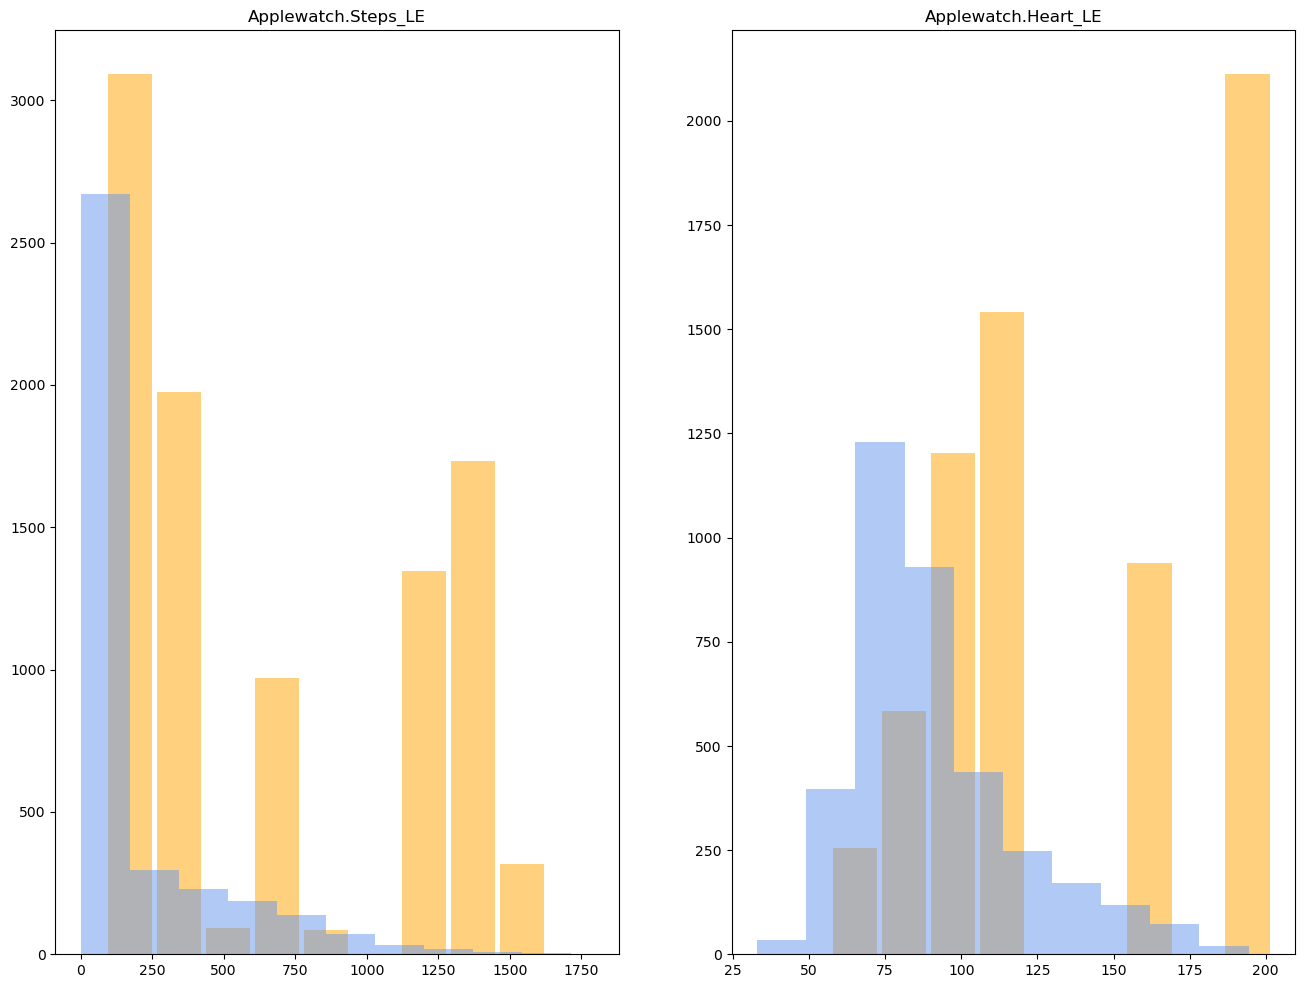

In [221]:
eps=0.001
fig, axs = plt.subplots(1, 2, sharey=False, figsize=(16, 12))
fig.subplots_adjust(hspace=0.35)

for i in range(len(column_names)):
    ax = axs.flat[i]
    ax.set_title(column_names[i])
    #ax.set_ylim(0, 1)
    _bound = bounds[i]
    n_bins = 10
    bar_width = (_bound[1] - _bound[0]) / n_bins * 0.9

    hist, bins = dp.tools.histogram(data[column_names[i]], range=_bound, density=False, bins=n_bins, epsilon=eps)
    ax.bar(bins[:-1] + np.diff(bins), hist, alpha=0.5, width=bar_width, color='orange')
    
    _ = ax.hist(data[column_names[i]], alpha=0.5, density=False, bins=n_bins, color='cornflowerblue')

plt.show()

**Question 3c:** Change the value of eps in the code above and rerun it. What do you notice about the histograms as you increase or decrease eps?

**Answer:** Increasing eps doesn't change too much, but decreasing eps changes the yellow distribution.

## 4. Federated Models <a id="four"></a>

Federated learning is when models are trained on datasets that have **not** been collected together into a single training set, i.e. the data is federated, or distributed, across devices or databases, and there is no sharing or moving of data between devices. There is a single global model that needs to be trained on the federated data by training smaller models locally on the device itself, and then only the weights (or gradients) will be shared back to a central server that hosts the main global model. Those weights are then aggregated in some way to update the global model.

There are a few python libraries that can demonstrate federated learning, but they tend to have a steep learning curve since federated learning is very complex. Instead, let's just implement it from scratch in a simplistic way using the ID that we created from the dataset before.

In [32]:
# Find the unique IDs
unique_ids = np.unique(X_train_id)
unique_ids

array(['18_1_180.3', '18_1_183.0', '19_0_172.0', '19_1_180.0',
       '19_1_183.0', '20_1_168.0', '20_1_180.0', '20_1_184.0',
       '22_0_168.0', '22_1_180.0', '22_1_185.0', '23_0_160.0',
       '23_0_177.8', '23_1_178.0', '23_1_181.0', '24_0_165.0',
       '25_0_157.5', '25_0_160.0', '25_0_166.0', '25_1_160.0',
       '26_1_182.0', '27_1_176.0', '28_1_176.0', '29_0_159.0',
       '29_0_163.0', '30_0_164.0', '30_0_168.0', '30_1_182.0',
       '31_0_158.0', '31_0_164.0', '31_0_168.0', '31_1_191.0',
       '32_1_177.0', '32_1_180.0', '33_0_163.7', '35_0_160.0',
       '36_0_157.5', '36_0_172.0', '36_1_173.0', '37_0_157.0',
       '37_1_183.0', '39_0_173.0', '46_0_157.5', '48_1_170.0',
       '49_0_152.0', '53_0_143.0', '56_1_164.0'], dtype=object)

In [33]:
# Split the data array based on the IDs
client_x = [X_train[X_train_id == id_] for id_ in unique_ids]
client_y = [y_train[X_train_id == id_] for id_ in unique_ids]

In [40]:
# Print the resulting arrays to check we're doing it right
for i, array in enumerate(split_data):
    print(f"Array for ID {unique_ids[i]}:\n{array}")

NameError: name 'split_data' is not defined

In this next step, now that we've divided our training data into several training sets using the unique IDs, is to train LASSO models using only the data from each ID (ignoring the data in the test set). Then, we can implement the simplest version of federated learning called FederatedAveraging, which you can read about [here](https://arxiv.org/pdf/1602.05629.pdf). In a nutshell, we let each *client* or device train a local model, in parallel, and return the *weights* or coefficients to the server. Then, the server takes a weighted average of the coefficients, weighted by the size of the data on each client.

In the code below, we are creating a simple function that just trains each model separately and aggregates the results, with no respect for the whole client-server relationship. But that's ok! If you'd prefer a slightly more realistic scenario you can look at the [`flwr`](https://flower.ai/) library which will actually simulate the different clients and the server by running them all in separate terminals.

In [41]:
# Define the federated learning function
def federated_learning(client_xdata, client_ydata):
    # Train local models on client data
    local_weights = []
    local_n = []
    for X, y in zip(client_x, client_y):
        local_n.append(X.shape[0])
        local_model = LogisticRegression(solver='liblinear', multi_class='auto', C=.01)
        local_model.fit(X, y)
        local_weights.append(local_model.coef_)

    return local_weights, local_n

# Run the federated learning process
global_model, local_ns = federated_learning(client_x, client_y)

global_model = np.array(global_model).reshape((47,16))
federated_coefs = np.sum(global_model * np.array(local_ns)[:, None], axis=0, keepdims=True)/X_train.shape[0]
federated_coefs

array([[ 0.00207591,  0.00276534,  0.00156234,  0.00165072,  0.00374329,
        -0.0550562 ,  0.00162568,  0.01513131, -0.00320578, -0.0001804 ,
        -0.00099188,  0.02094537, -0.0610056 , -0.06145467,  0.00679805,
         0.00346918]])

Once we have our coefficients estimated using the FederatedAveraging approach, we can take a look at them and compare them to the coefficients we obtained from our centralized model.

In [42]:
np.mean(np.abs(l_model.coef_-federated_coefs))

0.04506659358314971

In [43]:
np.round(l_model.coef_, 3)

array([[ 0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,
         0.   ,  0.   ,  0.   ,  0.002, -0.015, -0.574,  0.059,  0.   ]])

In [44]:
np.round(federated_coefs, 3)

array([[ 0.002,  0.003,  0.002,  0.002,  0.004, -0.055,  0.002,  0.015,
        -0.003, -0.   , -0.001,  0.021, -0.061, -0.061,  0.007,  0.003]])

**Question 4a:** What did you notice about the coefficients estimated by the federated model versus the centralized model?

**Answer:** federated model has coefficients close to 0 while centralized model sets many coefficients as 0.

**Question 4b:** Why might our federated model be so much different than our centralized model? Please do not just say "because we don't have enough user data". That part is a given. Suppose we did have more user's devices, then explain why it might take so long for the federated model to converge to something resembling the centralized model.

**Answer:** Federated model requires each device typically has its own local dataset which doesn't necessarily represent the whole data set while centrallized method takes into account of all data available.

## 5. Conclusion <a id="five"></a>

In the above notebook we were able to demonstrate in simple terms the concepts of DP and FL on a dataset of Apple Watch data for multiple users. Remember that we implemented the most simplistic versions of both of these concepts, and we did everything on our local machines. These are fairly complex topics, and FL in particular can be extremely difficult to implement in a real production environment, hence the main reason it is not more popularly used in industry outside of larger tech companies that can afford to hire people with expertise in these areas.

Although we did not discuss it in much detail, there are weaknesses with the amount of privacy that is guaranteed by FL and DP. There may still be ways to reconstruct raw data instances with FL, and with DP the amount of privacy is dependent on $\epsilon$. In FL, we could go one step further in increasing privacy by implementing DP on the clients so that the actual weights sent back to the central server are differentially private, making it even more difficult to identify individual user's and their data.

### Privacy as Civil Right

**Question 5:** Now let's wrap things up by referring back to one of the papers that we read, Privacy as Civil Right by Alvaro M Bedoya. Please relate what was written in this piece to something you've personally experienced. Be sure to tie your experience to specific examples given in the text. I will be grading this one based on: (1) the personal experience you describe; (2) the clarity and organization of your response; and (3) the integration of the reading into your response. This does not have to be a formal essay with an introduction paragraph, 3 supporting paragraphs, and a conclusion paragraph, but if that helps you organize your thoughts, then feel free to write in that way. 

Write your response below.